# 5.1 Evalulating generative text model

In [135]:
import torch
import tiktoken
from previous_chapters import GPTModel
from previous_chapters import generate_text_simple
from previous_chapters import create_dataloader_v1


## 5..1.1 Using GPT to Generate Text

In [136]:


GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
    }
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [137]:
def text_to_token_ids(text , tokenizer ):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return  encoded_tensor

In [138]:
start_context= "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = text_to_token_ids(start_context, tokenizer)

token_ids

tensor([[6109, 3626, 6100,  345]])

In [139]:
def token_ids_to_text(token_ids, tokenizer):
  flat =token_ids.squeeze(0)

  decoded = tokenizer.decode(token_ids.squeeze().tolist())
  return decoded
  print(decoded)

token_ids_to_text(token_ids, tokenizer)

'Every effort moves you'

In [140]:
token_ids= generate_text_simple(
    model= model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens= 10,
    context_size = GPT_CONFIG_124M["context_length"]
)


In [141]:
token_ids.squeeze(0).shape

torch.Size([14])

In [142]:
token_ids_to_text(token_ids, tokenizer)


'Every effort moves you rentingetic wasnم refres RexMeCHicular stren'

## 5.1.2 calculating the Text generation Loss : cross_entropy and perplexity

In [143]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [144]:
with torch.no_grad():
  logits = model(inputs)


In [145]:
logits.shape

torch.Size([2, 3, 50257])

In [146]:
probas = torch.softmax(logits, dim = -1 )
print(probas.shape)
print(probas)

torch.Size([2, 3, 50257])
tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]])


In [147]:
token_ids = torch.argmax(probas, dim =-1 , keepdim = True  )
print("token IDs :\n", token_ids)


token IDs :
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [148]:
print(f"Target_batch 1:{token_ids_to_text(targets[0], tokenizer)}")
print(f"Output_batch 1:{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Target_batch 1: effort moves you
Output_batch 1: Armed heNetflix


In [149]:
text_idx =0
target_probas_1 = probas[text_idx , [0,1,2], targets[text_idx]]
print("Text 1:", target_probas_1 )

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])


In [150]:
text_idx =1
output_probas_2 = probas[text_idx , [0,1,2], targets[text_idx]]
print("Text 2 :", output_probas_2 )

Text 2 : tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [151]:
log_probas = torch.log(torch.cat((target_probas_1, output_probas_2)))
print("Log Probas :", log_probas)

Log Probas : tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [152]:
-1*torch.mean(log_probas)

tensor(10.7940)

In [153]:
logits.shape

torch.Size([2, 3, 50257])

In [154]:
logits_flats = logits.flatten(0, 1)
logits_flats.shape

torch.Size([6, 50257])

In [155]:
targets_flats = targets.flatten()
targets_flats.shape

torch.Size([6])

In [156]:
torch.nn.functional.cross_entropy(logits_flats , targets_flats)

tensor(10.7940)

## 5.1.3 Calculating the training and validation set losses

In [157]:
import os
import requests

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


In [158]:
text_data[:99]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no '

In [159]:
text_data[-240:]

'off?"\n\nHe stood up and laid his hand on my shoulder with a laugh. "Only the irony of it is that I _am_ still painting--since Grindle\'s doing it for me! The Strouds stand alone, and happen once--but there\'s no exterminating our kind of art."'

In [160]:
total_characters = len(text_data)
total_tokens= len ( tokenizer.encode(text_data))

print(f"Total characters in the text file: {total_characters}")
print(f"Total tokens in the text file: {total_tokens}")

Total characters in the text file: 20479
Total tokens in the text file: 5145


In [161]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [162]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [163]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [164]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [165]:
def cal_loss_batch(input_batch , target_batch , model, device):
  input_batch , target_batch = input_batch.to(device), target_batch.to(device)
  logits= model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())

  return loss

def calc_loss_loader(data_loader , model, device , num_batches = None ):
  total_loss =0.
  if len(data_loader) == 0 :
     return  float("nan")

  elif num_batches is None :
    num_batches = len( data_loader )
  else :

    num_batches = min(num_batches , len(data_loader))
  for i , ( input_batch, target_batch) in enumerate(data_loader ):
    if i< num_batches:
      loss = cal_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break

  return total_loss /num_batches




In [166]:
device = torch.device("cpu")
device

device(type='cpu')

In [167]:
model.to(device);

In [168]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Train loss:", train_loss)
print("Validation loss:", val_loss)

Train loss: 10.98758347829183
Validation loss: 10.981106758117676


In [169]:
# perplexity

torch.exp(torch.tensor([0.5]))

tensor([1.6487])

In [170]:
tokenizer.n_vocab

50257

# 5.2 Training an LLM

In [171]:
def train_model_simple(model, train_loader , val_loader , optimizer , device , num_epochs,
                       eval_freq, eval_iter , start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen =[],[],[]
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader :
      optimizer.zero_grad()
      loss = cal_loss_batch(input_batch , target_batch, model, device )

      loss.backward()
      optimizer.step()
      tokens_seen += input_batch.numel()
      global_step +=1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader, val_loader ,
                                              device , eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"ep{epoch+1 })(step{global_step:06d}):"
                f"train loss {train_loss:.3f}, val loss {val_loss:.3f}")

    generate_and_print_sample(
            model, tokenizer, device, start_context
        )

  return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()



In [172]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device);
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay = 0.1)

In [104]:
nums_epochs = 10
train_losses, val_losses, track_tokens_seen = train_model_simple(
    model, train_loader, val_loader , optimizer, device,
    num_epochs = nums_epochs ,
    eval_freq= 5 , eval_iter= 5,
    start_context= "Every effort moves you", tokenizer= tokenizer
)


ep1)(step000000):train loss 9.783, val loss 9.927
ep1)(step000005):train loss 7.985, val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
ep2)(step000010):train loss 6.753, val loss 7.048
ep2)(step000015):train loss 6.114, val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
ep3)(step000020):train loss 5.525, val loss 6.490
ep3)(step000025):train loss 5.324, val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
ep4)(step000030):train loss 4.761, val loss 6.360
ep4)(step000035):train loss 4.461, val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
ep5)(step000040):train loss 3.833, val loss 6.196
Every effort moves you know the "Oh, and he was 

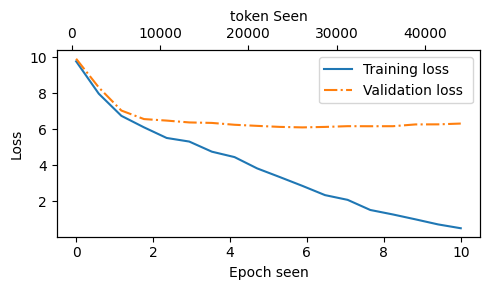

In [173]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses( epoch_seen, tokens_seen , train_losses, val_losses):
  fig ,ax1 = plt.subplots(figsize=(5,3))

  ax1.plot(epoch_seen , train_losses, label = "Training loss ")
  ax1.plot(epoch_seen , val_losses, linestyle ='-.',  label = "Validation loss ")
  ax1.set_xlabel("Epoch seen")
  ax1.set_ylabel("Loss")
  ax1.legend(loc= "upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses , alpha =0)
  ax2.set_xlabel("token Seen")

  fig.tight_layout()
  plt.savefig("loss-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0, nums_epochs , len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen , train_losses, val_losses)

# 5.3 Decoding strategies to control randomness

In [174]:
model.to("cpu")
model.eval()


tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx= text_to_token_ids("Every Effort moves you ", tokenizer),
    max_new_tokens = 25,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("output text:\n ", token_ids_to_text(token_ids, tokenizer))

output text:
  Every Effort moves you  List debunk BooneyetPython inherit reactorsYetodynamic Sweden handful manage Daly steps Campus residingilot DelawareRANT inconvenience 160 convention 1957 auxSession


## 5.3.1 Temprature scaling

In [175]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab= {v:k for k, v in vocab.items()}
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [176]:
next_tokens_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probas= torch.softmax(next_tokens_logits , dim =0 )
probas


tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [177]:
next_token_id = torch.argmax(probas).item()
next_token_id

3

In [178]:
inverse_vocab[next_token_id]

'forward'

In [179]:
torch.manual_seed(123)

next_token_id = torch.multinomial(probas , num_samples =1 ).item()
print(inverse_vocab[next_token_id])

toward


In [180]:
def print_sampled_tokens(probas):
  torch.manual_seed(123)
  sample = [torch.multinomial(probas, num_samples =1 ).item() for i in range ( 1_000)]
  sample_ids = torch.bincount(torch.tensor(sample), minlength = len(probas))

  for i ,freq in enumerate( sample_ids ):
    print (f"{freq} * {inverse_vocab[i]}")

print_sampled_tokens(probas)


71 * closer
2 * every
0 * effort
544 * forward
2 * inches
1 * moves
0 * pizza
376 * toward
4 * you


In [181]:
def softmax_with_temprature(logits , temperature ):
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits , dim = 0 )

temperature = [1, 0.5 , 2,3,5]

scaled_probas = [softmax_with_temprature(next_tokens_logits, T ) for T in temperature ]

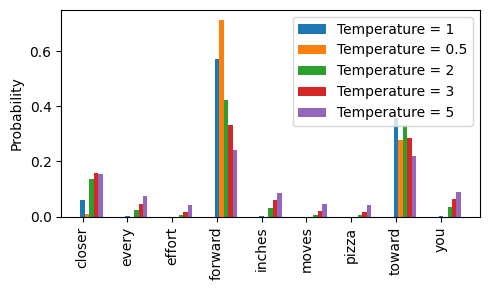

In [182]:
x = torch.arange(len(vocab))
bar_width = 0.10

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperature):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [183]:
print_sampled_tokens(scaled_probas[0])

71 * closer
2 * every
0 * effort
544 * forward
2 * inches
1 * moves
0 * pizza
376 * toward
4 * you


In [184]:
print_sampled_tokens(scaled_probas[3])

163 * closer
43 * every
28 * effort
303 * forward
75 * inches
23 * moves
15 * pizza
291 * toward
59 * you


## 5.3.2 Top-k sampling

In [185]:
top_k =3
top_logits , top_pos = torch.topk(next_tokens_logits , top_k )

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [186]:
new_logits =  torch.where (
    condition = next_tokens_logits < top_logits[-1],
    input= torch.tensor(float("-inf")),
    other = next_tokens_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [187]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## 5.3.3 modifying the text generation functon

In [188]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]#.unsqueeze(-1)
            logits = torch.where(
                logits < min_val,
                torch.tensor(float("-inf"), device=logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            logits = logits - logits.max(dim=-1, keepdim=True).values
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if eos_id is not None and (idx_next == eos_id).all():
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx


In [189]:

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you inferred rolleduint fabricationagos remarkably hereuced saints freewaylookOkayRand salary baseless


# 5.4 Loading and saving model weights in PyTorch

In [194]:
torch.save(model.state_dict(), "model.pth")

# 5.5 Loading pretrained weights from OpenAI

## Normal code to pretraing

In [195]:
# ! pip install tensorflow tqdm

In [196]:
from importlib.metadata import version
from gpt_download import download_and_load_gpt2
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.17.0
tqdm version: 4.67.1


In [197]:
settings , params = download_and_load_gpt2(model_size = "124M", models_dir = "gpt2")

In [198]:
print("setting " , settings)

setting  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [199]:
print("parameter dictionnary keys :", params.keys())

parameter dictionnary keys : dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [200]:
print(params['wte'])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [201]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
    }
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();



In [202]:
def assign(left , right ):
  if left.shape!= right.shape:
    raise ValueError(f"shape mismatch. left : {left.shape}, right{right.shape}")

  return torch.nn.Parameter(torch.tensor(right))


In [203]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

In [204]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the
